In [42]:
import logging
from datetime import datetime

import numpy as np

logger = logging.getLogger(__name__)
np.random.seed(2019)

log_path = datetime.now().strftime('./logs/%Y-%m-%d-%H-%M-%S.log')
logging.basicConfig(filename=log_path, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler())

In [43]:
import os

import numpy as np

def load_data(dp):
    x = []
    for fn in sorted(os.listdir(dp), key=lambda y: int(y[:-4])):
        with open('{dp}{fn}'.format(dp=dp, fn=fn), 'r') as f:
            x.append(f.read())
    return x

x_tr_pos = np.array(load_data('./dataset/train/pos/'), dtype=np.str)
x_tr_neg = np.array(load_data('./dataset/train/neg/'), dtype=np.str)
x_tr = np.concatenate((x_tr_pos, x_tr_neg), axis=0)
y_tr = np.concatenate((np.ones_like(x_tr_pos, dtype=np.float64), np.zeros_like(x_tr_neg, dtype=np.float64)), axis=0)
x_ts = np.array(load_data('./dataset/test/'), dtype=np.str)

del x_tr_pos
del x_tr_neg

In [44]:
# NOTE: This is a necessary step to prevent KFold splits consisting only one class

from sklearn.utils import shuffle

x_tr, y_tr = shuffle(x_tr, y_tr)

In [45]:
import string

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def preprocessor(s):
    s = s.lower()
    s = s.replace('<br /><br />', ' ')
    s = s.replace('-', ' ')
    s = s.replace('/', ' ')
    for ws in string.whitespace:
        s.replace(ws, ' ')
    s = s.translate(s.maketrans('', '', string.punctuation))
    s = s.translate(s.maketrans('', '', string.digits))
    s = ''.join(filter(lambda x: x in string.printable, s))
    return s

def tokenizer(s):
    wl = WordNetLemmatizer()
    st = SnowballStemmer('english', ignore_stopwords=True)
    ts = word_tokenize(s, 'english')
    ts = list(filter(lambda x: x not in stopwords.words('english'), ts))
    ts = list(map(lambda x: wl.lemmatize(x), ts))
    ts = list(map(lambda x: st.stem(x), ts))
    return ts

token_pattern = r'\w+|[%s]' % string.punctuation

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tf_idf_transform(x_tr, x_ts):
    st_time = datetime.now()

    tf_idf = TfidfVectorizer(token_pattern=token_pattern,
                             ngram_range=(1, 3))
    x_tr = tf_idf.fit_transform(x_tr)
    x_ts = tf_idf.transform(x_ts)

    fn_time = datetime.now()
    logger.info('Total Time Tfidf Vectorizer: {tt}'.format(tt=fn_time - st_time))

    return x_tr, x_ts

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

def count_transform(x_tr, x_ts):
    st_time = datetime.now()

    cnt = CountVectorizer(token_pattern=token_pattern,
                          ngram_range=(1, 3))
    x_tr = cnt.fit_transform(x_tr)
    x_ts = cnt.transform(x_ts)

    fn_time = datetime.now()
    logger.info('Total Time Count Vectorizer: {tt}'.format(tt=fn_time - st_time))

    return x_tr, x_ts

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

def binary_transform(x_tr, x_ts):
    st_time = datetime.now()

    cnt = CountVectorizer(token_pattern=token_pattern,
                          ngram_range=(1, 3),
                          binary=True)
    x_tr = cnt.fit_transform(x_tr)
    x_ts = cnt.transform(x_ts)

    fn_time = datetime.now()
    logger.info('Total Time Binary Vectorizer: {tt}'.format(tt=fn_time - st_time))

    return x_tr, x_ts

In [49]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, KFold

def k_fold_cross_validation(k, cl, x_tr, y_tr, vec):
    st_time = datetime.now()

    cv_s = []
    kf_res = []
    for i, (tr_idx, cv_idx) in enumerate(KFold(n_splits=k).split(x_tr)):
        x_cnt_tr, x_cnt_ts = vec(x_tr[tr_idx], x_tr[cv_idx])
        cl.fit(x_cnt_tr, y_tr[tr_idx])

        kf_res.append((cl.predict(x_cnt_tr), cl.predict(x_cnt_ts)))
        cv_s.append(f1_score(y_tr[cv_idx], kf_res[-1][1]))

        logger.info('KFold {} CV Score: {}'.format(i, cv_s[-1]))
    logger.info('KFold Mean CV Score: {}'.format(sum(cv_s) / k))

    fn_time = datetime.now()
    logger.info('Total Time KFold CV ({k}): {tt}'.format(k=k, tt=fn_time - st_time))

    return kf_res

In [50]:
def predict_test(cl, x_tr, y_tr, x_ts, fn, vec):
    st_time = datetime.now()

    x_tr, x_ts = vec(x_tr, x_ts)
    cl.fit(x_tr, y_tr)
    with open('./results/{fn}.csv'.format(fn=fn), 'w') as f:
        f.write('Id,Category\n')
        prd = cl.predict(x_ts)
        for i, y_i in enumerate(prd):
            f.write('{i},{y_i}\n'.format(i=i, y_i=int(y_i)))

    fn_time = datetime.now()
    logger.info('Total Time Prediction: {tt}'.format(tt=fn_time - st_time))

    return prd, cl.predict(x_tr)

In [51]:
from sklearn.base import clone

def run_model(cl, k, x_tr, y_tr, x_ts, vec, fn):
    kf_res_ = k_fold_cross_validation(k, clone(cl), x_tr, y_tr, vec)
    prd_ts, prd_tr = predict_test(clone(cl), x_tr, y_tr, x_ts, fn, vec)
    return kf_res_, prd_ts, prd_tr

In [18]:
from sklearn.linear_model import LogisticRegression

cl_lr = LogisticRegression(solver='lbfgs', n_jobs=-1)
logger.info('LogisticRegression Binary:')
kf_res_lr_bn, prd_ts_lr_bn, prd_tr_lr_bn = run_model(cl_lr, 5, x_tr, y_tr, x_ts,
                                                     binary_transform, 'logistic_regression_binary')
logger.info('\nLogisticRegression Count:')
kf_res_lr_cn, prd_ts_lr_cn, prd_tr_lr_cn = run_model(cl_lr, 5, x_tr, y_tr, x_ts,
                                                     count_transform, 'logistic_regression_count')
logger.info('\nLogisticRegression Tfidf:')
kf_res_lr_ti, prd_ts_lr_ti, prd_tr_lr_ti = run_model(cl_lr, 5, x_tr, y_tr, x_ts,
                                                     tf_idf_transform, 'logistic_regression_tfidf')

LogisticRegression Binary:
Total Time Binary Vectorizer: 0:01:00.733377
KFold 0 CV Score: 0.8950715421303658
Total Time Binary Vectorizer: 0:01:01.976838
KFold 1 CV Score: 0.8957403651115617
Total Time Binary Vectorizer: 0:00:57.816473
KFold 2 CV Score: 0.9057560975609756
Total Time Binary Vectorizer: 0:00:48.505445
KFold 3 CV Score: 0.9042298483639266
Total Time Binary Vectorizer: 0:00:50.064177
KFold 4 CV Score: 0.8960601861017621
KFold Mean CV Score: 0.8993716078537183
Total Time KFold CV (5): 0:12:40.833318
Total Time Binary Vectorizer: 0:01:18.556920
Total Time: 0:02:55.437742

LogisticRegression Count:
Total Time Count Vectorizer: 0:00:50.297688
KFold 0 CV Score: 0.8994624726259207
Total Time Count Vectorizer: 0:00:50.157655
KFold 1 CV Score: 0.8986390412350193
Total Time Count Vectorizer: 0:00:49.716529
KFold 2 CV Score: 0.9006648416112631
Total Time Count Vectorizer: 0:00:48.494790
KFold 3 CV Score: 0.9008828250401284
Total Time Count Vectorizer: 0:00:50.024349
KFold 4 CV Score

In [12]:
from sklearn.svm import LinearSVC

cl_ls = LinearSVC()
logger.info('LinearSVC Binary:')
kf_res_ls_bn, prd_ts_ls_bn, prd_tr_ls_bn = run_model(cl_ls, 5, x_tr, y_tr, x_ts,
                                                     binary_transform, 'linear_svc_binary')
logger.info('\nLinearSVC Count:')
kf_res_ls_cn, prd_ts_ls_cn, prd_tr_ls_cn = run_model(cl_ls, 5, x_tr, y_tr, x_ts,
                                                     count_transform, 'linear_svc_count')
logger.info('\nLinearSVC Tfidf:')
kf_res_ls_ti, prd_ts_ls_ti, prd_tr_ls_ti = run_model(cl_ls, 5, x_tr, y_tr, x_ts,
                                                     tf_idf_transform, 'linear_svc_tfidf')

LinearSVC Binary:
Total Time Binary Vectorizer: 0:01:07.914878
/usr/local/anaconda3/envs/comp551/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
KFold 0 CV Score: 0.893879173290938
Total Time Binary Vectorizer: 0:01:06.806678
KFold 1 CV Score: 0.89353921170256
Total Time Binary Vectorizer: 0:00:59.259294
KFold 2 CV Score: 0.90234375
Total Time Binary Vectorizer: 0:00:55.502179
KFold 3 CV Score: 0.9022827392871445
Total Time Binary Vectorizer: 0:01:15.495726
KFold 4 CV Score: 0.8973851030110934
KFold Mean CV Score: 0.8978859954583471
Total Time KFold CV (5): 0:14:12.685909
Total Time Binary Vectorizer: 0:01:38.467866
Total Time: 0:03:38.600600

LinearSVC Count:
Total Time Count Vectorizer: 0:00:59.177755
KFold 0 CV Score: 0.8993235177079187
Total Time Count Vectorizer: 0:01:06.051668
KFold 1 CV Score: 0.8942561396387253
Total Time Count Vectorizer:

In [13]:
from nbsvm import NBSVM

cl_ns = NBSVM()
logger.info('NBSVM Binary:')
kf_res_ns_bn, prd_ts_ns_bn, prd_tr_ns_bn = run_model(cl_ns, 5, x_tr, y_tr, x_ts,
                                                     binary_transform, 'nb_svm_binary')
logger.info('\nNBSVM Count:')
kf_res_ns_cn, prd_ts_ns_cn, prd_tr_ns_cn = run_model(cl_ns, 5, x_tr, y_tr, x_ts,
                                                     count_transform, 'nb_svm_count')
logger.info('\nNBSVM Tfidf:')
kf_res_ns_ti, prd_ts_ns_ti, prd_tr_ns_ti = run_model(cl_ns, 5, x_tr, y_tr, x_ts,
                                                     tf_idf_transform, 'nb_svm_tfidf')

NBSVM Binary:
Total Time Binary Vectorizer: 0:00:52.467374
KFold 0 CV Score: 0.9195219123505977
Total Time Binary Vectorizer: 0:01:03.812329
KFold 1 CV Score: 0.9164985881403792
Total Time Binary Vectorizer: 0:01:41.508223
KFold 2 CV Score: 0.9159647404505387
Total Time Binary Vectorizer: 0:00:54.580028
KFold 3 CV Score: 0.9248554913294798
Total Time Binary Vectorizer: 0:00:57.474764
KFold 4 CV Score: 0.921825396825397
KFold Mean CV Score: 0.9197332258192784
Total Time KFold CV (5): 0:16:47.133925
Total Time Binary Vectorizer: 0:01:29.264890
Total Time: 0:03:25.421935

NBSVM Count:
Total Time Count Vectorizer: 0:00:51.945422
KFold 0 CV Score: 0.9227101132525333
Total Time Count Vectorizer: 0:01:03.228642
KFold 1 CV Score: 0.91727199354318
Total Time Count Vectorizer: 0:01:00.438501
KFold 2 CV Score: 0.9143976493633693
Total Time Count Vectorizer: 0:01:06.740401
KFold 3 CV Score: 0.9226464121527084
Total Time Count Vectorizer: 0:00:52.781187
KFold 4 CV Score: 0.9235946159936659
KFold Me

In [14]:
from sklearn.naive_bayes import BernoulliNB

cl_bn = BernoulliNB()
logger.info('BernoulliNB Binary:')
kf_res_bn_bn, prd_ts_bn_bn, prd_tr_bn_bn = run_model(cl_bn, 5, x_tr, y_tr, x_ts,
                                                     binary_transform, 'bernoulli_naive_bayes_binary')
logger.info('\nBernoulliNB Count:')
kf_res_bn_cn, prd_ts_bn_cn, prd_tr_bn_cn = run_model(cl_bn, 5, x_tr, y_tr, x_ts,
                                                     count_transform, 'bernoulli_naive_bayes_count')
logger.info('\nBernoulliNB Tfidf:')
kf_res_bn_ti, prd_ts_bn_ti, prd_tr_bn_ti = run_model(cl_bn, 5, x_tr, y_tr, x_ts,
                                                     tf_idf_transform, 'bernoulli_naive_bayes_tfidf')

BernoulliNB Binary:
Total Time Binary Vectorizer: 0:00:50.554297
KFold 0 CV Score: 0.8691430983537357
Total Time Binary Vectorizer: 0:00:51.120874
KFold 1 CV Score: 0.8892116182572614
Total Time Binary Vectorizer: 0:00:52.904800
KFold 2 CV Score: 0.8671563483735572
Total Time Binary Vectorizer: 0:00:50.753494
KFold 3 CV Score: 0.8765224695506089
Total Time Binary Vectorizer: 0:00:51.343319
KFold 4 CV Score: 0.8746318889356332
KFold Mean CV Score: 0.8753330846941593
Total Time KFold CV (5): 0:04:38.677145
Total Time Binary Vectorizer: 0:01:21.364457
Total Time: 0:01:23.710896

BernoulliNB Count:
Total Time Count Vectorizer: 0:00:52.309309
KFold 0 CV Score: 0.8691430983537357
Total Time Count Vectorizer: 0:00:54.923399
KFold 1 CV Score: 0.8892116182572614
Total Time Count Vectorizer: 0:00:51.249935
KFold 2 CV Score: 0.8671563483735572
Total Time Count Vectorizer: 0:00:53.471255
KFold 3 CV Score: 0.8765224695506089
Total Time Count Vectorizer: 0:00:50.836715
KFold 4 CV Score: 0.8746318889

In [16]:
from sklearn.naive_bayes import MultinomialNB

cl_mn = MultinomialNB()
logger.info('MultinomialNB Binary:')
kf_res_mn_bn, prd_ts_mn_bn, prd_tr_mn_bn = run_model(cl_mn, 5, x_tr, y_tr, x_ts,
                                                     binary_transform, 'multinomial_naive_bayes_binary')
logger.info('\nMultinomialNB Count:')
kf_res_mn_cn, prd_ts_mn_cn, prd_tr_mn_cn = run_model(cl_mn, 5, x_tr, y_tr, x_ts,
                                                     count_transform, 'multinomial_naive_bayes_count')
logger.info('\nMultinomialNB Tfidf:')
kf_res_mn_ti, prd_ts_mn_ti, prd_tr_mn_ti = run_model(cl_mn, 5, x_tr, y_tr, x_ts,
                                                     tf_idf_transform, 'multinomial_naive_bayes_tfidf')

MultinomialNB Binary:
Total Time Binary Vectorizer: 0:01:07.101059
KFold 0 CV Score: 0.8868889343424013
Total Time Binary Vectorizer: 0:01:00.631669
KFold 1 CV Score: 0.8912952936276552
Total Time Binary Vectorizer: 0:01:02.588041
KFold 2 CV Score: 0.8844118844118843
Total Time Binary Vectorizer: 0:00:52.684926
KFold 3 CV Score: 0.8873239436619719
Total Time Binary Vectorizer: 0:01:10.023258
KFold 4 CV Score: 0.8906633906633907
KFold Mean CV Score: 0.8881166893414607
Total Time KFold CV (5): 0:05:34.226930
Total Time Binary Vectorizer: 0:01:24.975771
Total Time: 0:01:26.701356

MultinomialNB Count:
Total Time Count Vectorizer: 0:00:53.129203
KFold 0 CV Score: 0.8822567457072772
Total Time Count Vectorizer: 0:00:50.348165
KFold 1 CV Score: 0.8866108786610877
Total Time Count Vectorizer: 0:00:50.417470
KFold 2 CV Score: 0.8769574944071589
Total Time Count Vectorizer: 0:00:48.970740
KFold 3 CV Score: 0.8786749482401657
Total Time Count Vectorizer: 0:00:50.059661
KFold 4 CV Score: 0.884465

In [71]:
# NOTE: The logic of CV in this stacking has some problems.
import numpy as np
from sklearn.linear_model import LogisticRegression

cv_s = []
cls_cv = [
    kf_res_lr_bn, kf_res_lr_cn, kf_res_lr_ti,
    kf_res_ls_bn, kf_res_ls_cn, kf_res_ls_ti,
    kf_res_ns_bn, kf_res_ns_cn, kf_res_ns_ti,
    kf_res_bn_bn, kf_res_bn_cn, kf_res_bn_ti,
    kf_res_mn_bn, kf_res_mn_cn, kf_res_mn_ti,
    KFold(n_splits=5).split(x_tr)
]
cl_stk_lr = LogisticRegression(solver='lbfgs', n_jobs=-1)
for i, kf_i in enumerate(zip(*cls_cv)):
    cl_stk_lr.fit(np.concatenate(list(map(lambda x: x[0].reshape((-1, 1)), kf_i[:-1])), axis=1), y_tr[kf_i[-1][0]])
    cv_s.append(f1_score(y_tr[kf_i[-1][1]], cl_stk_lr.predict(np.concatenate(list(map(lambda x: x[1].reshape((-1, 1)), kf_i[:-1])), axis=1))))
    logger.info('KFold {} CV Score: {}'.format(i, cv_s[-1]))
logger.info('KFold Mean CV Score: {}'.format(sum(cv_s) / len(cv_s)))

KFold 0 CV Score: 0.91256721768572
KFold 1 CV Score: 0.9136603161734901
KFold 2 CV Score: 0.9109803921568628
KFold 3 CV Score: 0.91705161679052
KFold 4 CV Score: 0.914228855721393
KFold Mean CV Score: 0.9136976797055972


In [72]:
import numpy as np

cls_ts = [
    prd_ts_lr_bn, prd_ts_lr_cn, prd_ts_lr_ti,
    prd_ts_ls_bn, prd_ts_ls_cn, prd_ts_ls_ti,
    prd_ts_ns_bn, prd_ts_ns_cn, prd_ts_ns_ti,
    prd_ts_bn_bn, prd_ts_bn_cn, prd_ts_bn_ti,
    prd_ts_mn_bn, prd_ts_mn_cn, prd_ts_mn_ti,
]
cls_tr = [
    prd_tr_lr_bn, prd_tr_lr_cn, prd_tr_lr_ti,
    prd_tr_ls_bn, prd_tr_ls_cn, prd_tr_ls_ti,
    prd_tr_ns_bn, prd_tr_ns_cn, prd_tr_ns_ti,
    prd_tr_bn_bn, prd_tr_bn_cn, prd_tr_bn_ti,
    prd_tr_mn_bn, prd_tr_mn_cn, prd_tr_mn_ti,
]
cl_stk_lr.fit(np.concatenate(list(map(lambda x: x.reshape((-1, 1)), cls_tr)), axis=1), y_tr)
with open('./results/stacked_everything.csv', 'w') as f:
    f.write('Id,Category\n')
    prd = cl_stk_lr.predict(np.concatenate(list(map(lambda x: x.reshape((-1, 1)), cls_tr)), axis=1))
    for i, y_i in enumerate(prd):
        f.write('{i},{y_i}\n'.format(i=i, y_i=int(y_i)))

In [ ]:
# NOTE: Only run this to generate the info gain csv
from datetime import datetime

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vecs = [(TfidfVectorizer(token_pattern=token_pattern, ngram_range=(1, 3)), 'tf_idf'),
        (CountVectorizer(token_pattern=token_pattern, ngram_range=(1, 3)), 'count'),
        (CountVectorizer(token_pattern=token_pattern, ngram_range=(1, 3), binary=True), 'binary')]
for vec, vec_nm in vecs[::-1]:
    st_time = datetime.now()

    mu_ig = mutual_info_classif(vec.fit_transform(x_tr), y_tr)

    fn_time = datetime.now()
    logger.info('Total Time Prediction: {tt}'.format(tt=fn_time - st_time))

    with open('./files/information_gain_{vec_nm}.csv'.format(vec_nm=vec_nm), 'w') as f:
        for mi_i, fn_i in sorted(zip(mu_ig, fn), key=lambda x: -x[0]):
            f.write('{mi_i},{fn_i}\n'.format(mi_i=mi_i, fn_i=fn_i))

In [34]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, clss, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(clss))
    plt.xticks(tick_marks, clss, rotation=45)
    plt.yticks(tick_marks, clss)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

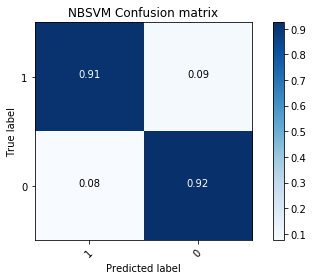

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

np.set_printoptions(precision=2)
plt.figure()
cnfs = []
for (_, y_tr_prd), (idx_tr, idx_cv) in zip(kf_res_ns_bn, KFold(n_splits=5).split(x_tr)):
    cnfs.append(confusion_matrix(y_tr[idx_cv], y_tr_prd))
plot_confusion_matrix(sum(cnfs) / len(cnfs), ['1', '0'], title='NBSVM Confusion matrix')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()